In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

### 1次元の畳み込みニューラルネットワークスクラッチ

In [167]:
class SimpleConv1d:
    """
    チャンネル数を1に限定した1次元畳み込み層のクラス
    """
    def __init__(self, f_size, initializer = Q3_Initializer(), optimizer = SGD(0.01)):
        self.optimizer = optimizer # 最適化手法
        self.W = initializer.W(f_size) # 重み
        self.B = 1 # バイアス
        self.f_size = f_size # フィルターのサイズ
        self.n_stride = 1 # ストライド数
        self.n_padding = 0 # パディング数
        self.n_output = None
        self.X = None
        self.dW = None
        self.dB = None
    
    """
    フォワード
    """
    def forward(self, X):
        
        self.X = X
        self.calc_n_out()
        X_mini_list = self.get_receptive_field()
        a = X_mini_list@self.W + self.B
    
    """
    バックワード
    """
    def backward(self, dA):
        
        self.dB = np.sum(dA, axis=0)
        
        X_mini_list = self.get_receptive_field()
        self.dW = dA@X_mini_list
        
        w_list = np.zeros((self.n_output, self.X.shape[0]))
        put_idx = np.arange(self.f_size)
        for i in range(self.n_output):
            wi = np.zeros(self.X.shape[0])
            np.put(wi, put_idx + np.array([i]), self.W)
            w_list[i] = wi
        dX = dA@w_list

        self.optimizer.update(self)
        
        return dX
    
    """
    1次元畳み込み後の出力サイズの計算
    """
    def calc_n_out(self):
        self.n_output = int((self.X.shape[0] + 2*self.n_padding - self.f_size)/self.n_stride + 1)
    
    """
    受容野を取得する
    """
    def get_receptive_field(self):
        
        X_mini_list = np.zeros((self.n_output, self.f_size))
        
        for i in range(self.n_output):
            for s in range(self.f_size):
                X_mini_list[i][s] = self.X[i+s]
        
        return X_mini_list
        

#### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [3]:
"""
確率的勾配降下法
"""
class SGD:
    
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

### 【問題3】小さな配列での1次元畳み込み層の実験

In [156]:
"""
【問題3】小さな配列での1次元畳み込み層の実験用の初期化クラス
"""
class Q3_Initializer:
    
    def W(self, f_size):
        return np.array([3, 5, 7]).astype(np.float64)
    
    def B(self):
        return np.array([1])

In [157]:
x = np.array([1,2,3,4])

sc1 = SimpleConv1d(3)
sc1.forward(x)
dx = sc1.backward(np.array([10, 20]))

# 期待値
# delta_b = np.array([30])
# delta_w = np.array([50, 80, 110])
# delta_x = np.array([30, 110, 170, 140])

# 結果
print(" sc1.dB:", sc1.dB)
print(" sc1.dW:", sc1.dW)
print(" dx:", dx)

    out: 2
    X: (4,)
[35. 50.]
    out: 2
    X: (4,)
 sc1.dB: 30
 sc1.dW: [ 50.  80. 110.]
 dx: [ 30. 110. 170. 140.]


### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [158]:
"""
【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成用の初期化クラス
"""
class Q4_Initializer:
    
    def W(self, f_size):
        return np.ones((3, 2, 3))
    
    def B(self):
        return np.array([1, 2, 3])

In [159]:
class SimpleConv1d_2:
    """
    チャンネル数を限定しない1次元畳み込み層クラスの作成
    """
    def __init__(self, f_size, initializer = Q4_Initializer(), optimizer = SGD(0.01)):
        self.optimizer = optimizer # 最適化手法
        self.W = initializer.W(f_size) # 重み
        self.B = initializer.B() # バイアス
        self.f_size = f_size # フィルターのサイズ
        self.n_f = self.W.shape[0] # フィルターの数
        self.n_stride = 1 # ストライド数
        self.n_padding = 0 # パディング数
        self.n_output = None
        self.X = None
        self.dW = None
        self.dB = None
    
    """
    フォワード
    """
    def forward(self, X):
        
        self.X = X
        self.calc_n_out()
        a = np.zeros((self.f_size, self.n_output))
        
        for i in range(self.n_f):
            for j in range(self.n_output):
                
                X_mini_list = self.get_receptive_field(X[j])
                a[i][j] = np.sum(X_mini_list@self.W[i][j])
            
            a[i] = a[i] + self.B[i]
            
        return a
        
    """
    バックワード
    """
    def backward(self, dA):
        
        self.dB = np.sum(dA, axis=0)
        
        X_mini_list = self.get_receptive_field()
        self.dW = dA@X_mini_list
        
        w_list = np.zeros((self.n_output, self.X.shape[0]))
        put_idx = np.arange(self.f_size)
        for i in range(self.n_output):
            wi = np.zeros(self.X.shape[0])
            np.put(wi, put_idx + np.array([i]), self.W)
            w_list[i] = wi
        dX = dA@w_list

        self.optimizer.update(self)
        
        return dX
    
    """
    1次元畳み込み後の出力サイズの計算
    """
    def calc_n_out(self):
        self.n_output = int((self.X.shape[1] + 2*self.n_padding - self.f_size)/self.n_stride + 1)
        
    """
    受容野を取得する
    """
    def get_receptive_field(self, X):
        
        X_mini_list = np.zeros((self.n_output, self.f_size))
        
        for i in range(self.n_output):
            for s in range(self.f_size):
                X_mini_list[i][s] = X[i+s]
        
        return X_mini_list

In [160]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）
# a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

sc2 = SimpleConv1d_2(3)
a = sc2.forward(x)
print(a)

[[16. 22.]
 [17. 23.]
 [18. 24.]]


### 【問題8】学習と推定

In [174]:
def out_size(in_size, f, p=0, s=1):
    return int((in_size+2*p-f) // s) + 1

In [175]:
class Conv1d_3:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, st=1):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.st = st
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa, self.st)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        
        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        
        return A
    
    def backward(self, dA):

        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        
        self.optimizer.update(self)
        return dX

In [176]:
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
class ActSigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class ActTanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class ActSoftmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    
    def loss_func(self, Y, Z=None):
        """
        y_true : (n_samples, n_output)
        z : (n_samples, n_output)
        """
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ActReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class ScratchConvNeuralNetrowkClassifier:
    
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, 
                 n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 verbose=True, Activater=ActTanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        # self.n_nodes1 = n_nodes1 # 1層目のノード数 # self.conv1d_3.n_out になる
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        
        self.Activater = Activater
        if Activater == ActSigmoid or Activater == ActTanh:
            self.Initializer = XavierInitializer
        elif Activater == ActReLU:
            self.Initializer = HeInitializer
        else:
            print("活性化関数が不適切")
        self.Optimizer = Optimizer
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
        #optimizer = self.Optimizer(self.lr)
        self.conv1d_3 = Conv1d_3(filter_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=3, st=2)
        self.conv1d_3.n_out = out_size(X.shape[-1], self.conv1d_3.filter_size, self.conv1d_3.pa, self.conv1d_3.st)
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.conv1d_3.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = ActSoftmax()
        
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.iter = len(get_mini_batch)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))
        
        if self.verbose:
            self.learning_curve()
            print()
        
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def forward_propagation(self, X):
        A1 = self.conv1d_3.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
    def back_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.conv1d_3.backward(dA1) # dZ0は使用しない
    
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, self.num_epoch*self.iter + 1), self.loss, label="train_loss")
        plt.plot(np.arange(0, self.num_epoch + 1)*self.iter, self.loss_epoch, label="epoch_loss")
        if self.val_enable:
            plt.plot(np.arange(1, self.num_epoch + 1), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()
        return

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X@self.W + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [179]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

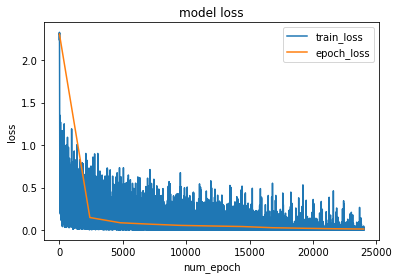


 score: 0.9758


In [180]:
from sklearn.metrics import accuracy_score
scratch_cnn1 = ScratchConvNeuralNetrowkClassifier(num_epoch=10, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Activater=ActTanh, Optimizer=SGD)
scratch_cnn1.fit(X_train_, y_train_)
y_pred1 = scratch_cnn1.predict(X_test)
score = accuracy_score(y_test, y_pred1)

print(" score:",score)